In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import networkx as nx
import ast

from nanonets import Simulation
from nanonets.utils import extract_harmonic_features
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.signal import correlate2d, correlate
from scipy.optimize import curve_fit
from scipy.linalg import eig

plt.style.use(["science","bright","grid"])
# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size/"
# PATH = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/amp_freq/"
PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/amp_freq_size/"

In [2]:
# PARAMETER
N_PARTICLES     = [3,5,7,9,11,13]
AMPLITUDE       = 0.02
AMPLITUDE_LIST  = [AMPLITUDE]
FREQ_LIST_MHZ   = [0.005,0.01,0.03,0.06,0.12,0.25,0.5,1.,2.,5.,6.,8.,
                   10.,12.,15.,18.,23.,28.,36.,44.,55.,68.,86.,105.,133.,266.,610.,1200.,2400.]
N_PERIODS       = 100
N_SKIP          = 80
SAMPLE_P_PERIOD = 40
N_ELECTRODES    = 8
N_NP            = 9
PLOT_SIZE_NORM  = Normalize(vmin=N_PARTICLES[0]**2, vmax=N_PARTICLES[-1]**2)

### Linear Limit

In [3]:
tau_t = {}
f_c_t = {}
for N_P in N_PARTICLES:
    topo = {"Nx": N_P,"Ny": N_P,
            "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                    [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                    [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
            "electrode_type": ['constant']*8}
    
    sim_c = Simulation(topo)
    sim_c.build_conductance_matrix()
    cap_m           = sim_c.get_capacitance_matrix()*1e-18
    g_m             = sim_c.get_conductance_matrix()[:-8,:-8]
    eigenvalues, _  = eig(g_m, cap_m)
    real_eigs       = np.real(eigenvalues)
    valid_eigs      = real_eigs[real_eigs > 1e-9]

    lambda_min = np.min(valid_eigs)
    tau_t[N_P] = 1.0 / lambda_min
    f_c_t[N_P] = lambda_min / (2*np.pi)

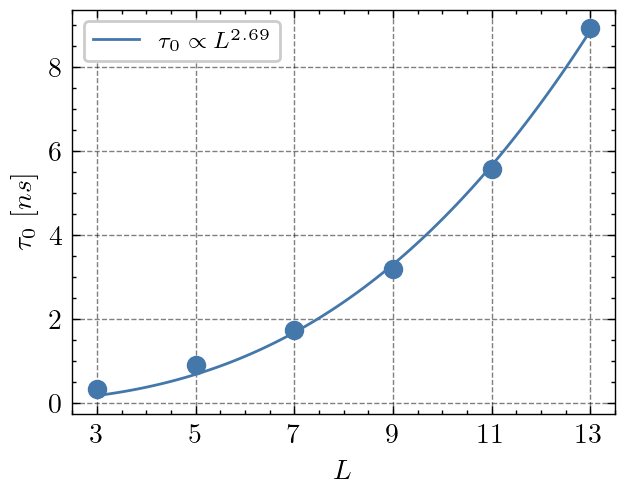

In [4]:
def power_law(x,a,b):
    return a*x**b

fig, ax = plt.subplots(dpi=200)
x_val   = np.linspace(N_PARTICLES[0],N_PARTICLES[-1],100)
p, _    = curve_fit(power_law, np.array(N_PARTICLES)[1:], [tau_t[N] for N in N_PARTICLES][1:])
pp      = ax.plot(np.array(N_PARTICLES), np.array([tau_t[N] for N in N_PARTICLES])*1e9, 'o')
_       = ax.plot(x_val, power_law(x_val, *p)*1e9, color=pp[0].get_color(), label=rf'$\tau_0 \propto L^{{{p[-1]:.2f}}}$')
_       = ax.set_xticks(N_PARTICLES)
_       = ax.set_xlabel("$L$")
_       = ax.set_ylabel("$\\tau_0~[ns]$")
leg     = ax.legend(fontsize='small')

### Load Data

In [ ]:
dts         = {freq : 1/(40 * freq * 1e6) for freq in FREQ_LIST_MHZ}
N_steps     = {freq : int(np.ceil((N_PERIODS / (freq * 1e6)) / dts[freq])) for freq in FREQ_LIST_MHZ}
time        = {freq : dts[freq]*np.arange(N_steps[freq]) for freq in FREQ_LIST_MHZ}
data        = {N : {freq : pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
states      = {N : {freq : pd.read_csv(f"{PATH}mean_state_Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv") for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
# currents    = {N : {freq : pd.read_csv(f"{PATH}net_currents_Nx={N}_Ny={N}_Ne=8_{freq:.3f}_{AMPLITUDE:.3f}.csv").iloc[N_SKIP*SAMPLE_P_PERIOD:,:]*1e-6
#                       for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

x = {N : {freq : data[N][freq]['E0'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
y = {N : {freq : data[N][freq]['Observable'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
e = {N : {freq : data[N][freq]['Error'].values[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}
p = {N : {freq : np.mean(states[N][freq].iloc[:,8:].values, axis=1)[N_SKIP*SAMPLE_P_PERIOD:].copy() for freq in FREQ_LIST_MHZ} for N in N_PARTICLES}

In [ ]:
# save_folder = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/dynamic/AC/amp_freq_size/"
# for N in N_PARTICLES:
#     for freq in FREQ_LIST_MHZ:
        # np.save(f"{save_folder}_x_{N}_{freq}.npy", x[N][freq])
        # np.save(f"{save_folder}_y_{N}_{freq}.npy", y[N][freq])
        # np.save(f"{save_folder}_p_{N}_{freq}.npy", p[N][freq])
        # np.save(f"{save_folder}_states_{N}_{freq}.npy", states[N][freq].iloc[N_SKIP*SAMPLE_P_PERIOD:,8:].values)
        # currents[N][freq].to_csv(f"{save_folder}_I_{N}_{freq}.csv")

In [ ]:
# x   = {}
# y   = {}
# p   = {}
# p_s = {}
# for N in N_PARTICLES:
#     x_tmp   = {}
#     y_tmp   = {}
#     p_tmp   = {}
#     p_s_tmp = {}
#     for freq in FREQ_LIST_MHZ:
#         x_tmp[freq] = np.load(f"{save_folder}_x_{N}_{freq}.npy")
#         y_tmp[freq] = np.load(f"{save_folder}_y_{N}_{freq}.npy")
#         p_tmp[freq] = np.load(f"{save_folder}_p_{N}_{freq}.npy")
#         p_s_tmp[freq] = np.load(f"{save_folder}_states_{N}_{freq}.npy")
#     x[N]    = x_tmp
#     y[N]    = y_tmp
#     p[N]    = p_tmp
#     p_s[N]  = p_s_tmp
#     currents[N][freq].to_csv(f"{save_folder}_I_{N}_{freq}.csv")

### AC-Gain vs System Size

In [ ]:
B       = 200
h0s_p   = {N : np.array([extract_harmonic_features(p[N][f0], n_vals=[1], mode='abs', pad_len=4096) for f0 in FREQ_LIST_MHZ]).flatten() for N in N_PARTICLES}
h0s_I   = {N : np.array([[extract_harmonic_features(y[N][f0]+np.random.normal(0, e[N][f0]/1.96), n_vals=[1], mode='abs', pad_len=4096) for _ in range(B)] for f0 in FREQ_LIST_MHZ]) for N in N_PARTICLES}
gain_p  = {N : 20*np.log10(h0s_p[N]/h0s_p[N][0]) for N in N_PARTICLES}
gain_I  = {N : 20*np.log10(h0s_I[N]/h0s_I[N][0]) for N in N_PARTICLES}

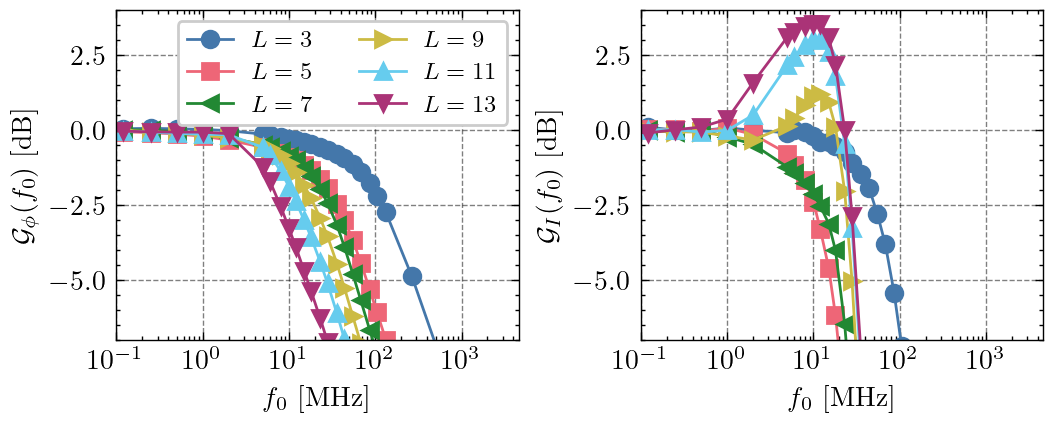

In [ ]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','<','>','^','v']

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*0.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Potential
for i, N in enumerate(N_PARTICLES):
    ax1.plot(FREQ_LIST_MHZ, gain_p[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax1.set_xscale('log')
_ = ax1.set_xlabel("$f_0$ [MHz]")
_ = ax1.set_ylabel("$\mathcal{G}_\phi(f_0)$ [dB]")
_ = ax1.set_xlim(1e-1)
_ = ax1.set_ylim(-7,4)
_ = ax1.legend(fontsize='small', loc='upper right', ncol=2)

# Current
for i, N in enumerate(N_PARTICLES):
    ax2.errorbar(FREQ_LIST_MHZ, np.mean(gain_I[N],axis=1).flatten(), np.std(gain_I[N],axis=1).flatten(), marker=marker[i])
_ = ax2.set_xscale('log')
_ = ax2.set_xlabel("$f_0$ [MHz]")
_ = ax2.set_ylabel("$\mathcal{G}_{I}(f_0)$ [dB]")
_ = ax2.set_xlim(1e-1)
_ = ax2.set_ylim(-7,4)

fig.savefig(f"plots/pdf/f0_gain_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/f0_gain_scaling.svg", transparent=True)
fig.savefig(f"plots/png/f0_gain_scaling.png", transparent=False)

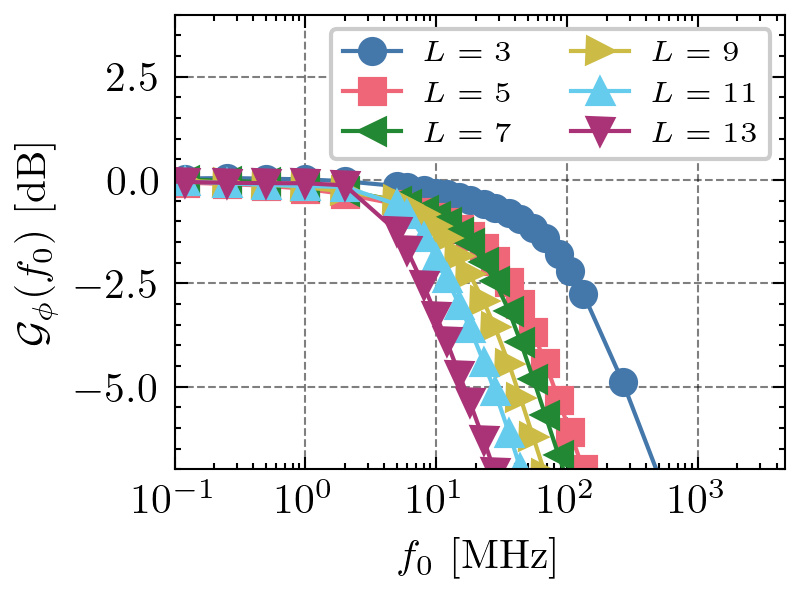

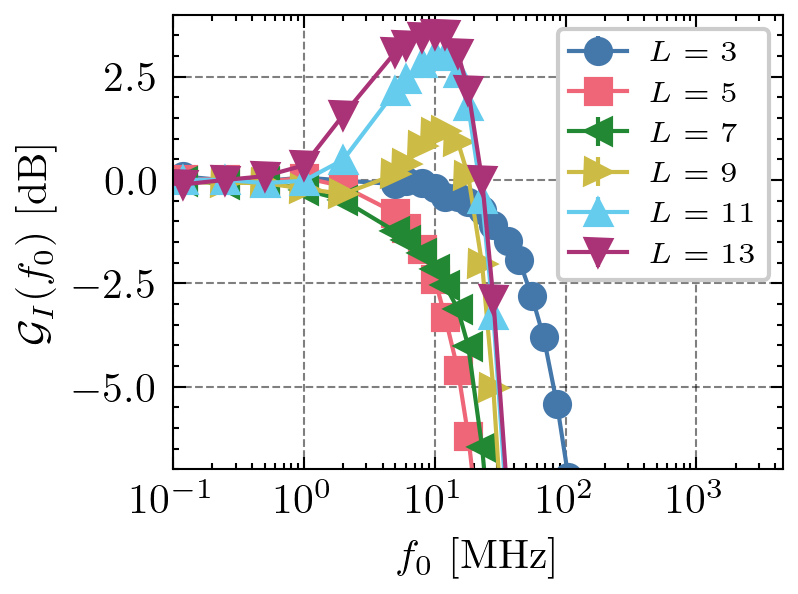

In [117]:
cmap    = plt.get_cmap('cividis')
marker  = ['o','s','<','>','^','v']

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Potential
for i, N in enumerate(N_PARTICLES):
    ax.plot(FREQ_LIST_MHZ, gain_p[N], marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}_\phi(f_0)$ [dB]")
_ = ax.set_xlim(1e-1)
_ = ax.set_ylim(-7,4)
_ = ax.legend(fontsize='x-small', loc='upper right', ncol=2)

fig.savefig(f"plots/pdf/pot_f0_gain_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/pot_f0_gain_scaling.svg", transparent=True)
fig.savefig(f"plots/png/pot_f0_gain_scaling.png", transparent=False)

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

# Current
for i, N in enumerate(N_PARTICLES):
    ax.errorbar(FREQ_LIST_MHZ, np.mean(gain_I[N],axis=1).flatten(), np.std(gain_I[N],axis=1).flatten(), marker=marker[i], label=rf'$L = {N}$')
_ = ax.set_xscale('log')
_ = ax.set_xlabel("$f_0$ [MHz]")
_ = ax.set_ylabel("$\mathcal{G}_{I}(f_0)$ [dB]")
_ = ax.set_xlim(1e-1)
_ = ax.set_ylim(-7,4)
_ = ax.legend(fontsize='x-small', loc='upper right', ncol=1)

fig.savefig(f"plots/pdf/I_f0_gain_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/I_f0_gain_scaling.svg", transparent=True)
fig.savefig(f"plots/png/I_f0_gain_scaling.png", transparent=False)

In [114]:
def extract_fc_from_gain(freqs, gain_db, threshold=-3.0):
    """Interpolates the frequency where Gain crosses threshold."""
    # Assuming monotonic rolloff in the cutoff region
    # Find last point above and first point below
    
    # Safety: Check if we ever cross
    if np.min(gain_db) > threshold:
        return np.nan
    
    # Find index where it drops
    idx = np.where(gain_db < threshold)[0][0]
    
    if idx == 0: return np.nan # Started below
    
    f1, f2 = freqs[idx-1], freqs[idx]
    g1, g2 = gain_db[idx-1], gain_db[idx]
    
    # Linear interpolation
    slope = (f2 - f1) / (g2 - g1)
    f_c = f1 + slope * (threshold - g1)
    
    return f_c

fc_current  = [extract_fc_from_gain(FREQ_LIST_MHZ, np.mean(gain_I[N],axis=1).flatten()) for N in N_PARTICLES]
fc_pot      = [extract_fc_from_gain(FREQ_LIST_MHZ, gain_p[N]) for N in N_PARTICLES]

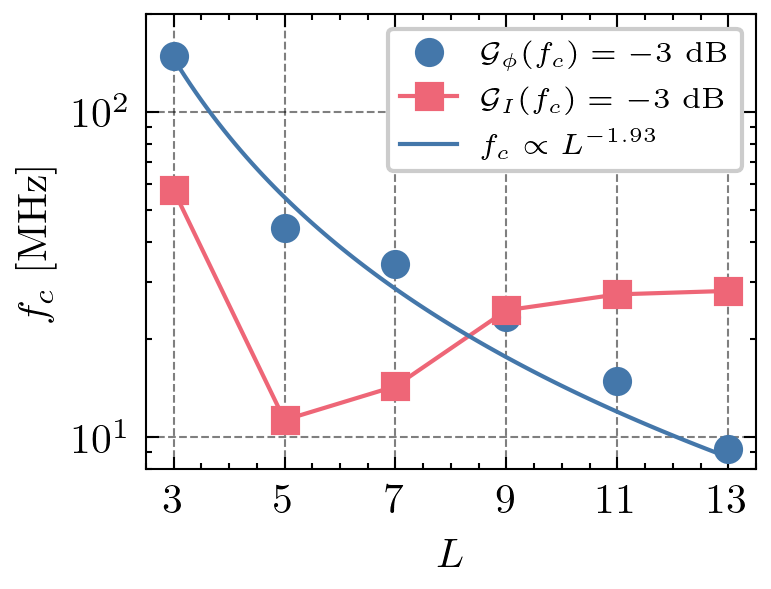

In [116]:
def power_law(x,a,b):
    return a*x**b

fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

f_vals  = np.linspace(N_PARTICLES[0], N_PARTICLES[-1], 100)
pp      = ax.plot(np.array(N_PARTICLES), fc_pot, marker='o', label='$\mathcal{G}_{\phi}(f_c) = -3~\mathrm{dB}$', ls='')
_       = ax.plot(np.array(N_PARTICLES), fc_current, marker='s', label='$\mathcal{G}_{I}(f_c) = -3~\mathrm{dB}$')
pa,_    = curve_fit(power_law, np.array(N_PARTICLES), fc_pot)
_       = ax.plot(f_vals, power_law(f_vals,*pa), label=f'$f_c \propto L^{{{pa[1]:.2f}}}$', color=pp[0].get_color())
_       = ax.set_ylabel('$f_c$ [MHz]')
_       = ax.set_xlabel('$L$')
_       = ax.legend(fontsize='x-small')
_       = ax.set_yscale('log')
_       = ax.set_ylim(8,200)
_       = ax.set_xticks(N_PARTICLES)

fig.savefig(f"plots/pdf/fc_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/fc_scaling.svg", transparent=True)
fig.savefig(f"plots/png/fc_scaling.png", transparent=False)

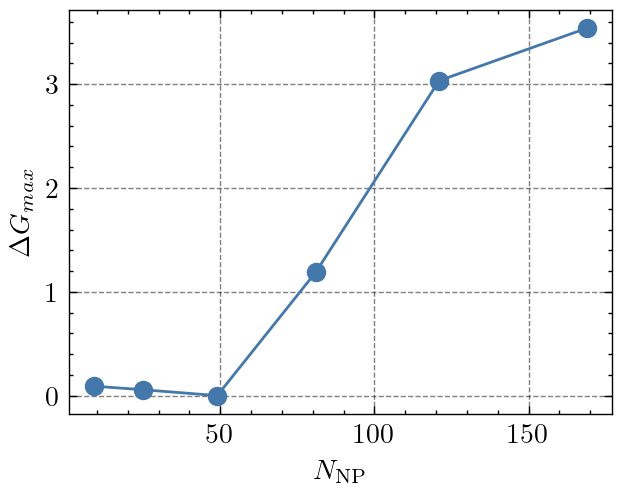

In [43]:
fig, ax = plt.subplots(dpi=200)
_   = ax.plot(np.array(N_PARTICLES)**2, [np.max([0,np.max(gain_currs[N])])-gain_currs[N][0] for N in N_PARTICLES], 'o-')
_   = ax.set_ylabel('$\Delta G_{max}$')
_   = ax.set_xlabel('$N_\\textrm{NP}$')
# _   = ax.set_xscale('log')

fig.savefig(f"plots/pdf/delta_G_max_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/delta_G_max_scaling.svg", transparent=True)
fig.savefig(f"plots/png/delta_G_max_scaling.png", transparent=False)

### Spatial Distribution

In [119]:
N_NP     = 13
topo = {"Nx": N_NP,"Ny": N_NP, "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],
               [0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],
               [N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
            "electrode_type": ['constant']*8}
sim_class   = Simulation(topo)
G_obj       = sim_class.get_graph()
pos         = sim_class.get_positions()
pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
E_CHARGE    = sim_class.ELE_CHARGE_A_C
CAP_MAT     = sim_class.get_capacitance_matrix()
t_points = [0,int(0.25*SAMPLE_P_PERIOD),int(0.5*SAMPLE_P_PERIOD),int(0.75*SAMPLE_P_PERIOD)]
phi_vecs = {}
q_vecs   = {}
t_vecs   = {}
x_vecs   = {}
y_vecs   = {}

for freq in FREQ_LIST_MHZ:

    t       = time[freq][:-1][:-N_SKIP*SAMPLE_P_PERIOD]*1e9
    phi_vec = p_s[N_NP][freq]
    q_vec   = (CAP_MAT @ phi_vec.T).T/E_CHARGE

    phi_vecs[freq]  = phi_vec.copy()
    q_vecs[freq]    = q_vec.copy()
    t_vecs[freq]    = t.copy()
    x_vecs[freq]    = x.copy()
    y_vecs[freq]    = y.copy()

In [120]:
def analyze_lattice_with_moments(arr: np.ndarray):
    """
    Analyzes the full 2D lattice using a model-free moment-based approach on projected profiles.

    Calculates the "center of charge" (mean) and "charge spread" (RMS width)
    for the FULL distribution projected onto the horizontal (x) and vertical (y) axes.

    Args:
        arr (np.ndarray): A 9x9 NumPy array of the lattice state (charge or potential).

    Returns:
        Tuple[float, float, float, float]: A tuple containing:
            - mean_x (float): The center of charge along the x-axis.
            - width_x (float): The RMS spread of charge along the x-axis (Lateral Spread).
            - mean_y (float): The center of charge along the y-axis (Penetration Depth).
            - width_y (float): The RMS spread of charge along the y-axis (Longitudinal Spread).
    """
    ny, nx = arr.shape
    x_coords = np.arange(nx)
    y_coords = np.arange(ny)

    # Use absolute values as weights (magnitude of excitation)
    weights = np.abs(arr)
    total_weight = np.sum(weights)

    # Avoid division by zero if there's no charge
    if total_weight == 0:
        return np.nan, np.nan, np.nan, np.nan

    # --- 1. Project 2D Data to 1D Axes ---
    # Instead of taking a single slice, we SUM over the perpendicular axis.
    # This captures charge moving in the "wings," not just the center line.
    profile_x = np.sum(weights, axis=0)  # Sum columns to get X distribution
    profile_y = np.sum(weights, axis=1)  # Sum rows to get Y distribution

    # --- 2. Calculate Moments for X ---
    # Mean position X
    mean_x = np.sum(x_coords * profile_x) / total_weight
    
    # RMS width X
    var_x = np.sum(((x_coords - mean_x)**2) * profile_x) / total_weight
    width_x = np.sqrt(var_x)

    # --- 3. Calculate Moments for Y ---
    # Mean position Y
    mean_y = np.sum(y_coords * profile_y) / total_weight
    
    # RMS width Y
    var_y = np.sum(((y_coords - mean_y)**2) * profile_y) / total_weight
    width_y = np.sqrt(var_y)

    return mean_x, width_x, mean_y, width_y

N_samples   = 20
q_c_max     = []
q_c_zero    = []
phi_c_max   = []
phi_c_zero  = []
charge      = True

for freq in FREQ_LIST_MHZ:
    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    q_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(q_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    q_c_max.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    phi_c_zero.append(vals)

    vals = [analyze_lattice_with_moments(phi_vecs[freq][i*SAMPLE_P_PERIOD + int(0.25*SAMPLE_P_PERIOD)].copy().reshape(N_NP,N_NP)) for i in range(N_samples)]
    phi_c_max.append(vals)

if charge:
    mean_x_max  = np.array([[q_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[q_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[q_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[q_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[q_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[q_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[q_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[q_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
else:
    mean_x_max  = np.array([[phi_c_max[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_max = np.array([[phi_c_max[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_max  = np.array([[phi_c_max[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_max = np.array([[phi_c_max[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

    mean_x_zero     = np.array([[phi_c_zero[i][j][0] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_x_zero    = np.array([[phi_c_zero[i][j][1] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    mean_y_zero     = np.array([[phi_c_zero[i][j][2] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])
    width_y_zero    = np.array([[phi_c_zero[i][j][3] for j in range(N_samples)] for i in range(len(FREQ_LIST_MHZ))])

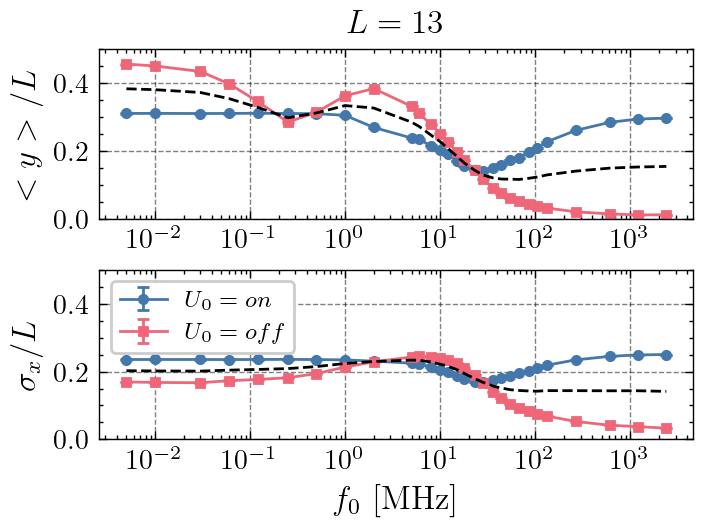

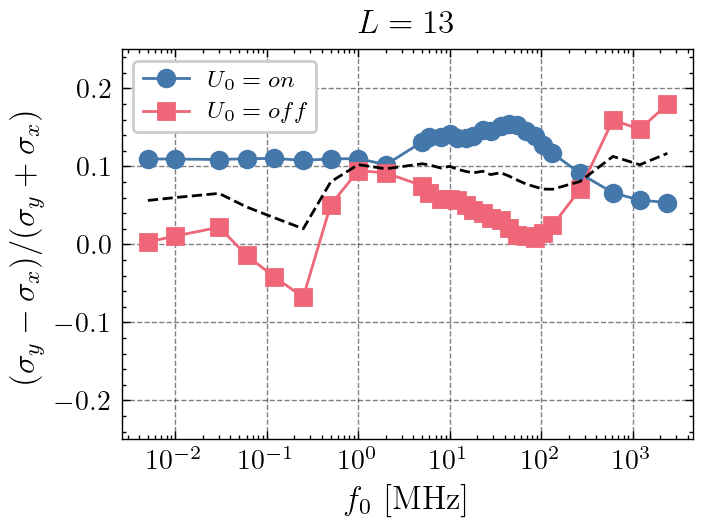

In [121]:
fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot(2,1,1)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_max,axis=1)/N_NP, 1.95*np.std(mean_y_max,axis=1)/(N_NP*np.sqrt(N_samples)), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(mean_y_zero,axis=1)/N_NP, 1.95*np.std(mean_y_zero,axis=1)/(N_NP*np.sqrt(N_samples)), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(mean_y_max,axis=1)+np.mean(mean_y_zero,axis=1))/(2*N_NP), '--', color='black', zorder=10)
_ = ax.set_title(f"$L = {N_NP}$")
_ = ax.set_ylabel("$<y> / L$", fontsize='large')
_ = ax.set_xscale('log')
_ = ax.set_ylim(0,0.5)
ax = fig.add_subplot(2,1,2)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_max,axis=1)/N_NP, 1.95*np.std(width_x_max,axis=1)/(N_NP*np.sqrt(N_samples)), marker='o', capsize=2, label='$U_0 = on$', ms=3)
ax.errorbar(FREQ_LIST_MHZ, np.mean(width_x_zero,axis=1)/N_NP, 1.95*np.std(width_x_zero,axis=1)/(N_NP*np.sqrt(N_samples)), marker='s', capsize=2, label='$U_0 = off$', ms=3)
ax.plot(FREQ_LIST_MHZ, (np.mean(width_x_max,axis=1)+np.mean(width_x_zero,axis=1))/(2*N_NP), '--', color='black', zorder=10)
_ = ax.set_xscale('log')
_ = ax.set_ylim(0,0.5)
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_ylabel("$\sigma_x / L$", fontsize='large')
_ = ax.legend(fontsize='small', loc='upper left')

if charge:
    fig.savefig(f"plots/svg/charge_penetration_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_penetration_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_penetration_{N_NP}.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_penetration_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_penetration_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_penetration_{N_NP}.png", transparent=False)

fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1)),'-o', label='$U_0 = on$')
ax.plot(FREQ_LIST_MHZ, (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)),'-s', label='$U_0 = off$')
ax.plot(FREQ_LIST_MHZ, ((np.mean(width_y_max,axis=1)-np.mean(width_x_max,axis=1))/(np.mean(width_y_max,axis=1)+np.mean(width_x_max,axis=1))+
                        (np.mean(width_y_zero,axis=1)-np.mean(width_x_zero,axis=1))/(np.mean(width_y_zero,axis=1)+np.mean(width_x_zero,axis=1)))/2, '--', color='black', zorder=10)
# _ = ax.set_title(f"$U_0 = {amp*1000}$ mV")
_ = ax.set_ylabel("$(\sigma_y-\sigma_x)/(\sigma_y+\sigma_x)$", fontsize='large')
_ = ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
_ = ax.set_xscale('log')
_ = ax.set_title(f"$L = {N_NP}$")
_ = ax.set_ylim(-0.25,0.25)
_ = ax.legend(fontsize='small', loc='upper left')
if charge:
    fig.savefig(f"plots/svg/charge_anisotropy_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/charge_anisotropy_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/charge_anisotropy_{N_NP}.png", transparent=False)
else:
    fig.savefig(f"plots/svg/pot_anisotropy_{N_NP}.svg", transparent=True)
    fig.savefig(f"plots/pdf/pot_anisotropy_{N_NP}.pdf", transparent=False)
    fig.savefig(f"plots/png/pot_anisotropy_{N_NP}.png", transparent=False)

---

In [40]:
def compute_decay_alpha(amplitudes, harmonic_orders):
    """
    Calculates the Power Law Decay exponent (alpha) by fitting log(A) vs log(n).
    
    Parameters:
    - amplitudes: Array of magnitudes (must match len of harmonic_orders)
    - harmonic_orders: Array of n values (e.g. [1, 3, 5, 7])
    
    Returns:
    - alpha: The positive decay slope. Returns NaN if fit fails.
    """
    # We typically fit starting from the first harmonic or the third (n=3) 
    # depending on if you want to include the fundamental in the slope.
    # Ideally, filter for n >= 3 to see the "tail" decay.
    
    mask = (harmonic_orders >= 3)# & (amplitudes > 1e-15) # Filter noise/fundamental
    
    x = harmonic_orders[mask]
    y = amplitudes[mask]

    # x = harmonic_orders
    # y = amplitudes
    
    if len(x) < 2:
        return np.nan
        
    try:
        # Fit log(A) = -alpha * log(n) + C
        coeffs = np.polyfit(np.log(x), np.log(y), 1)
        return -coeffs[0] # Return positive alpha
    except:
        return np.nan
    
def compute_spectral_entropy(amplitudes):
    """
    Calculates Shannon Entropy of the normalized power spectrum.
    Input: Array of amplitudes.
    """
    power_spectrum = amplitudes**2
    total_power = np.sum(power_spectrum)
    
    if total_power == 0:
        return 0.0
        
    # Normalize to get probability distribution p_n
    p = power_spectrum / total_power
    
    # Filter out zeros to avoid log(0)
    p = p[p > 0]
    
    return -np.sum(p * np.log(p))

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

N_periods   = 20
n_vals      = np.arange(1,11,2)
print(n_vals)
amplitudes  = {}
for N in N_PARTICLES:
    amps_tmp = []
    for freq in FREQ_LIST_MHZ:
        y_val       = y[N][freq].copy()
        N_samples   = len(y_val)
        window      = np.blackman(N_samples)
        y_windowed  = y_val * window
        w_gain      = np.sum(window) / N_samples
        fft_vals    = np.fft.rfft(y_windowed)
        amps_tmp2   = []
        for n in n_vals:
            k = n * N_periods
            if k < len(fft_vals):
                Z_k = fft_vals[k]
                mag = (np.abs(Z_k) * 2 / N_samples) / w_gain
                amps_tmp2.append(mag)
            else:
                amps_tmp2.append(0.0)
        amps_tmp2 = np.array(amps_tmp2)
        amps_tmp.append(amps_tmp2)
    amplitudes[N] = amps_tmp
alphas  = {N : [compute_decay_alpha(amplitudes[N][i], n_vals) for i in range(len(FREQ_LIST_MHZ))] for N in N_PARTICLES}
entropy = {N : [compute_spectral_entropy(amplitudes[N][i]) for i in range(len(FREQ_LIST_MHZ))] for N in N_PARTICLES}
thds    = {N : [compute_thd(amplitudes[N][i]) for i in range(len(FREQ_LIST_MHZ))] for N in N_PARTICLES}

[1 3 5 7 9]


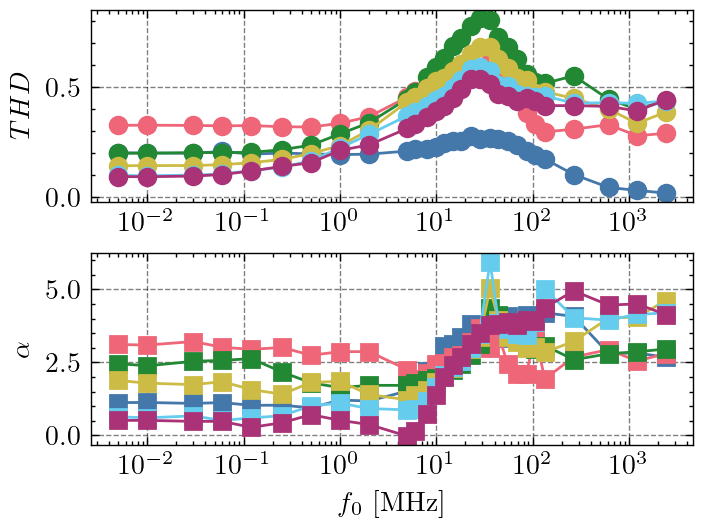

In [41]:
amp = 0.02
fig = plt.figure(dpi=200, layout='constrained')
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
# for amp in AMPLITUDE_LIST:
for N in N_PARTICLES:
    ax1.plot(FREQ_LIST_MHZ, thds[N], marker='o', label='$THD$')
    ax2.plot(FREQ_LIST_MHZ, alphas[N], marker='s', label='$\\alpha$')
_ = ax1.set_ylabel("$THD$")
_ = ax2.set_ylabel("$\\alpha$")
_ = ax2.set_xlabel("$f_0$ [MHz]")
ax1.set_xscale('log')
ax2.set_xscale('log')

fig.savefig(f"plots/pdf/THD_alpha_vs_f0_scaling.pdf", transparent=False)
fig.savefig(f"plots/svg/THD_alpha_vs_f0_scaling.svg", transparent=True)
fig.savefig(f"plots/png/THD_alpha_vs_f0_scaling.png", transparent=False)